In [65]:
from matplotlib import pyplot as plt
import os
import numpy as np
import json
from sklearn.linear_model import LinearRegression
import pandas as pd

file_dir = "../outputs/12_26/"
model_list = ["qwq", "qwen2.5-32b", "qwen2.5-14b", "qwen2.5-7b", "qwen2.5-3b"]#, "mistralai/Mathstral-7B-v0.1", "Skywork/Skywork-o1-Open-Llama-3.1-8B"]
latency_path = "/home/sunyi/CoT/Time-Constrained-CoT/latency/0107"
colors = ["red", "orange", "green", "blue", "purple", "pink", "brown", "gray", "black", "white"]

In [66]:
__MODEL_LIST__ = {
    # Qwen Models
    "qwen2.5-32b": "Qwen/Qwen2.5-32B-Instruct",
    "qwen2.5-14b": "Qwen/Qwen2.5-14B-Instruct",
    "qwen2.5-7b": "Qwen/Qwen2.5-7B-Instruct",
    "qwen2.5-3b": "Qwen/Qwen2.5-3B-Instruct",
    "qwen2.5-1.5b": "Qwen/Qwen2.5-1.5B-Instruct",
    "qwq": "Qwen/QwQ-32B-Preview",
    
    # Qwen Math Models
    "qwen2.5-math-7b": "Qwen/Qwen2.5-Math-7B-Instruct",
    "qwen2.5-math-1.5b": "Qwen/Qwen2.5-Math-1.5B-Instruct"
}

In [67]:
def get_latency_list(model_name, dataset):
    if dataset == "gsm8k":
        budget_list = []
        for i in range(25, 500, 25):
            budget_list.append(i)
        for i in range(500, 601, 50):
            budget_list.append(i)
    elif dataset == "math":
        budget_list = []
        for i in range(25, 976, 25):
            budget_list.append(i)
        # for i in range(1000, 1501, 50):
        #     budget_list.append(i)

    tokens = np.array([128, 256, 512, 1024])
    file = model_name + "_a800.csv"
    df = pd.read_csv(os.path.join(latency_path, file))
    latencies = df.iloc[0, 1:].values  # Extract latency values for the first row
    # Perform linear regression on the measured latency data
    linear_model = LinearRegression()
    tokens = tokens.reshape(-1, 1)
    linear_model.fit(tokens, latencies)
    print(f"File: {file} - Linear Fit: Slope = {linear_model.coef_[0]:.2f}, Intercept = {linear_model.intercept_:.2f}")
    print(f"File: {file} - R^2 Score: {linear_model.score(tokens, latencies):.2f}")
    # change budget_list into latency_list using the linear regression model
    budget_list = np.array(budget_list)
    budget_list = budget_list.reshape(-1, 1)
    latency_list = linear_model.predict(budget_list)
    budget_list = budget_list.reshape(1, -1)[0]
    latency_list = latency_list.reshape(1, -1)[0]

    return budget_list, latency_list


In [68]:
prompt_type1 = "qwen25-step-by-step-hard"
prompt_type2 = "qwen25-math-cot"
prompt_type3 = "coarse-to-fine-qwen"
prompt_type4 = "mathstral-step-by-step-hard"
prompt_type5 = "mathstral-step-by-step"
prompt_type6 = "mathstral-coarse-to-fine"
prompt_type7 = "skywork-step-by-step-hard"
prompt_type8 = "skywork-step-by-step"
prompt_type9 = "skywork-coarse-to-fine"

something = "_-1_seed0_t0.0_s0_e-1"

In [69]:
dataset = "gsm8k"
latency_lists = []
acc_lists_hard = []
acc_lists_sbs = []
acc_lists_c2f = []

for model in model_list:
    budget_list, latency_list = get_latency_list(model, dataset)
    acc_list_hard = []
    acc_list_sbs = []
    acc_list_c2f = []
    
    model = __MODEL_LIST__[model]
    for budget in budget_list:
        if model.startswith("Qwen"):
            file_name_hard = "test_" + prompt_type1 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_sbs = "test_" + prompt_type2 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_c2f = "test_" + prompt_type3 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path_hard = os.path.join(file_dir, model, prompt_type1, dataset, file_name_hard)
            file_path_sbs = os.path.join(file_dir, model, prompt_type2, dataset, file_name_sbs)
            file_path_c2f = os.path.join(file_dir, model, prompt_type3, dataset, file_name_c2f)
        elif model.startswith("mistralai"):
            file_name_hard = "test_" + prompt_type4 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_sbs = "test_" + prompt_type5 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_c2f = "test_" + prompt_type6 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path_hard = os.path.join(file_dir, model, prompt_type4, dataset, file_name_hard)
            file_path_sbs = os.path.join(file_dir, model, prompt_type5, dataset, file_name_sbs)
            file_path_c2f = os.path.join(file_dir, model, prompt_type6, dataset, file_name_c2f)
        elif model.startswith("Skywork"):
            file_name_hard = "test_" + prompt_type7 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_sbs = "test_" + prompt_type8 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_c2f = "test_" + prompt_type9 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path_hard = os.path.join(file_dir, model, prompt_type7, dataset, file_name_hard)
            file_path_sbs = os.path.join(file_dir, model, prompt_type8, dataset, file_name_sbs)
            file_path_c2f = os.path.join(file_dir, model, prompt_type9, dataset, file_name_c2f)
        with open(file_path_hard, "r") as f:
            acc_list_hard.append(json.load(f)["acc"])
        with open(file_path_sbs, "r") as f:
            acc_list_sbs.append(json.load(f)["acc"])
        with open(file_path_c2f, "r") as f:
            acc_list_c2f.append(json.load(f)["acc"])

    
    latency_lists.append(latency_list)
    acc_lists_hard.append(acc_list_hard)
    acc_lists_sbs.append(acc_list_sbs)
    acc_lists_c2f.append(acc_list_c2f)

File: qwq_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.28
File: qwq_a800.csv - R^2 Score: 1.00
File: qwen2.5-32b_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.34
File: qwen2.5-32b_a800.csv - R^2 Score: 1.00
File: qwen2.5-14b_a800.csv - Linear Fit: Slope = 0.03, Intercept = 0.14
File: qwen2.5-14b_a800.csv - R^2 Score: 1.00
File: qwen2.5-7b_a800.csv - Linear Fit: Slope = 0.02, Intercept = 0.02
File: qwen2.5-7b_a800.csv - R^2 Score: 1.00
File: qwen2.5-3b_a800.csv - Linear Fit: Slope = 0.03, Intercept = 0.02
File: qwen2.5-3b_a800.csv - R^2 Score: 1.00


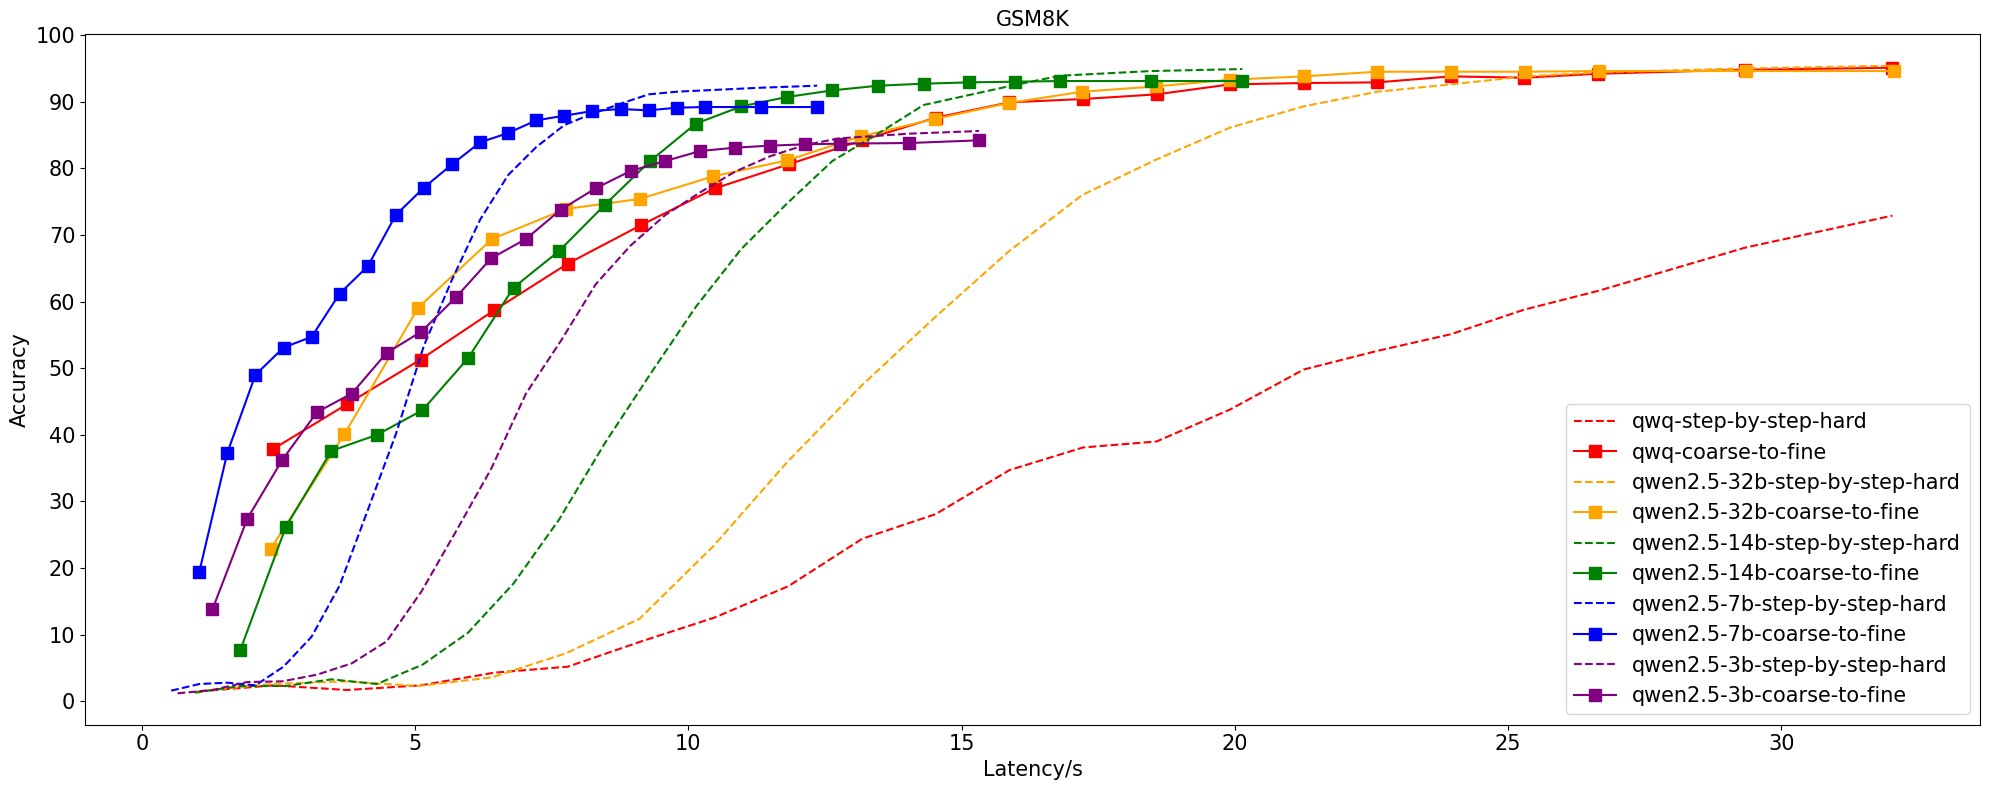

In [70]:
plt.figure(figsize=(20, 8))
marker_size = 8

for index, model in enumerate(model_list):
    plt.plot(latency_lists[index], acc_lists_hard[index], markersize=marker_size, linestyle='--', color=colors[index], label= model + "-step-by-step-hard")
    # plt.plot(latency_lists[index][1:], acc_lists_sbs[index][:-1], marker='^', linestyle='--', markersize=marker_size, color=colors[index], label= model + "-step-by-step")
    plt.plot(latency_lists[index][1:], acc_lists_c2f[index][:-1], marker='s', markersize=marker_size, color=colors[index], label= model + "-coarse-to-fine")

plt.xlabel("Latency/s", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title(f"{dataset.upper()}", fontsize=15)
plt.yticks(np.arange(0, 101, 10), fontsize=15)  # Set y-ticks interval to 10
plt.xticks(np.arange(0, 31, 5), fontsize=15)    # Set x-ticks interval to 5
# Move the legend to the bottom right corner
plt.legend(loc='lower right', fontsize=15)  # Set legend font size
# Adjust layout
plt.tight_layout()

In [71]:
dataset = "math"
latency_lists = []
acc_lists_hard = []
acc_lists_sbs = []
acc_lists_c2f = []

for model in model_list:
    budget_list, latency_list = get_latency_list(model, dataset)
    acc_list_hard = []
    acc_list_sbs = []
    acc_list_c2f = []
    
    model = __MODEL_LIST__[model]
    for budget in budget_list:
        if model.startswith("Qwen"):
            file_name_hard = "test_" + prompt_type1 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_sbs = "test_" + prompt_type2 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_c2f = "test_" + prompt_type3 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path_hard = os.path.join(file_dir, model, prompt_type1, dataset, file_name_hard)
            file_path_sbs = os.path.join(file_dir, model, prompt_type2, dataset, file_name_sbs)
            file_path_c2f = os.path.join(file_dir, model, prompt_type3, dataset, file_name_c2f)
        elif model.startswith("mistralai"):
            file_name_hard = "test_" + prompt_type4 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_sbs = "test_" + prompt_type5 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_c2f = "test_" + prompt_type6 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path_hard = os.path.join(file_dir, model, prompt_type4, dataset, file_name_hard)
            file_path_sbs = os.path.join(file_dir, model, prompt_type5, dataset, file_name_sbs)
            file_path_c2f = os.path.join(file_dir, model, prompt_type6, dataset, file_name_c2f)
        elif model.startswith("Skywork"):
            file_name_hard = "test_" + prompt_type7 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_sbs = "test_" + prompt_type8 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name_c2f = "test_" + prompt_type9 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path_hard = os.path.join(file_dir, model, prompt_type7, dataset, file_name_hard)
            file_path_sbs = os.path.join(file_dir, model, prompt_type8, dataset, file_name_sbs)
            file_path_c2f = os.path.join(file_dir, model, prompt_type9, dataset, file_name_c2f)
        with open(file_path_hard, "r") as f:
            acc_list_hard.append(json.load(f)["acc"])
        with open(file_path_sbs, "r") as f:
            acc_list_sbs.append(json.load(f)["acc"])
        with open(file_path_c2f, "r") as f:
            acc_list_c2f.append(json.load(f)["acc"])

    
    latency_lists.append(latency_list)
    acc_lists_hard.append(acc_list_hard)
    acc_lists_sbs.append(acc_list_sbs)
    acc_lists_c2f.append(acc_list_c2f)

File: qwq_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.28
File: qwq_a800.csv - R^2 Score: 1.00
File: qwen2.5-32b_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.34
File: qwen2.5-32b_a800.csv - R^2 Score: 1.00
File: qwen2.5-14b_a800.csv - Linear Fit: Slope = 0.03, Intercept = 0.14
File: qwen2.5-14b_a800.csv - R^2 Score: 1.00
File: qwen2.5-7b_a800.csv - Linear Fit: Slope = 0.02, Intercept = 0.02
File: qwen2.5-7b_a800.csv - R^2 Score: 1.00
File: qwen2.5-3b_a800.csv - Linear Fit: Slope = 0.03, Intercept = 0.02
File: qwen2.5-3b_a800.csv - R^2 Score: 1.00


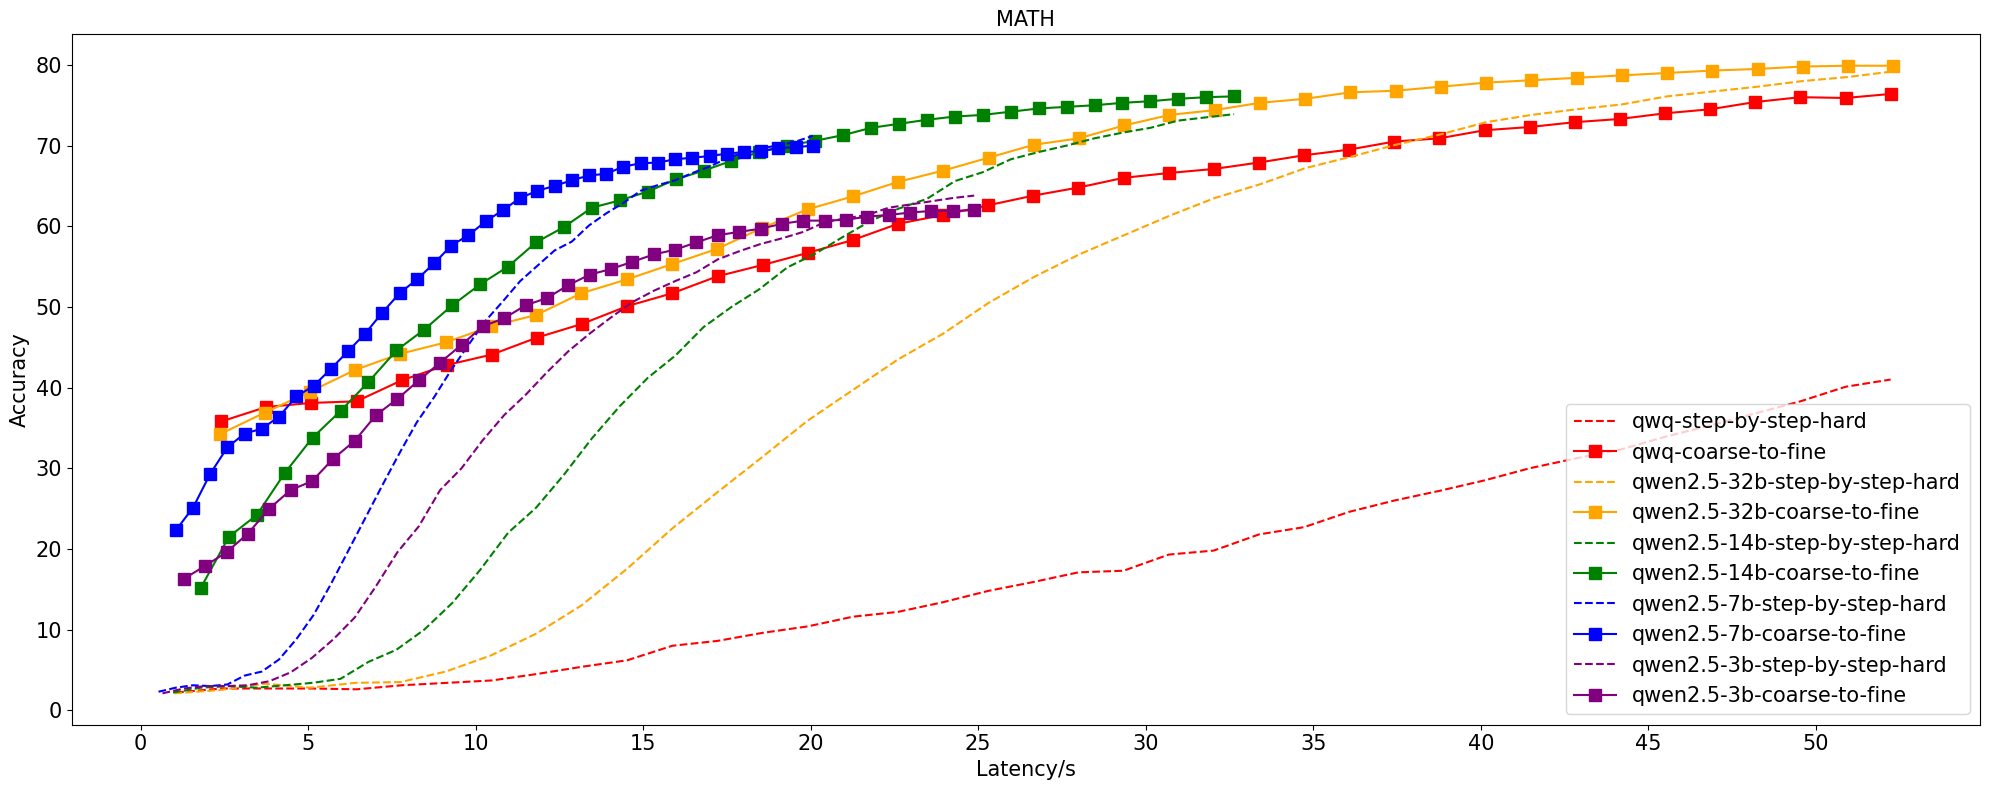

In [72]:
plt.figure(figsize=(20, 8))
marker_size = 8

for index, model in enumerate(model_list):
    plt.plot(latency_lists[index], acc_lists_hard[index], markersize=marker_size, linestyle='--', color=colors[index], label= model + "-step-by-step-hard")
    # plt.plot(latency_lists[index][1:], acc_lists_sbs[index][:-1], marker='^', linestyle='--', markersize=marker_size, color=colors[index], label= model + "-step-by-step")
    plt.plot(latency_lists[index][1:], acc_lists_c2f[index][:-1], marker='s', markersize=marker_size, color=colors[index], label= model + "-coarse-to-fine")

plt.xlabel("Latency/s", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title(f"{dataset.upper()}", fontsize=15)
plt.yticks(np.arange(0, 81, 10), fontsize=15)  # Set y-ticks interval to 10
plt.xticks(np.arange(0, 51, 5), fontsize=15)    # Set x-ticks interval to 5
# Move the legend outside the plot
plt.legend(loc='lower right', fontsize=15)
# Adjust layout
plt.tight_layout()